**V1-V9**

In [8]:
import numpy as np
import pandas as pd
import os
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from os import listdir
from pandas import read_csv, DataFrame
from tqdm import tqdm
from subprocess import call
from Bio.SeqIO import parse
from skbio.stats.composition import clr 


In [ ]:
pip install -U kaleido

In [9]:
def create_fasta(output, mearged_pike_out, dbpath):
    # Create fasta file 
    consensus = {}
    cons_conter = 0
    
    with open(f'{output}/all_consensus.fasta', 'w') as opn_fasta:
        for cons in mearged_pike_out.index:
    
            opn_fasta.write(f'>{cons_conter}\n{cons}\n')
            consensus[cons_conter] = cons
            cons_conter += 1
    
    return consensus
    
def run_blast(base, path):
    
    call(f'makeblastdb -in {base} -dbtype nucl', shell=True)
    call(f'blastn -num_threads 60  -outfmt "7 qseqid sseqid pident evalue qcovs bitscore" -query {path}/all_consensus.fasta  -db {base} -out {path}/blast_results.txt', shell=True)
 #   pass
def decode_tax(base) -> dict:
    
    # DB decoder 
    # Use db header format: Kingdom    Phylum    Class    Order    Family    Genus    Species
    
    base = parse(base, 'fasta')
    taxonomy_linage = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
    tax_decoder = {}
    
    for line in tqdm(base):
        
        tax_decoder[line.id] = {}
        linage = line.description.split(';')
        linage[0] = linage[0].split()[1]
    
        for i in range(len(taxonomy_linage)):
            try:
                if taxonomy_linage[i] != 'Species':
                
                    tax_decoder[line.id][taxonomy_linage[i]] = linage[i]
                
                else:
                    #print(linage[i].split())
                    tax_decoder[line.id][taxonomy_linage[i]] = ' '.join(linage[i].split()[:2])
                  
            except:
                
                tax_decoder[line.id][taxonomy_linage[i]] = 'NA'
    
    return tax_decoder

def parse_blast(path, 
                base, 
                data_tax, 
                consensus, 
                identity_filter, 
                cov_lim, 
                evalue_filter):
    
    # parser of blast table
    
    blast_header = ['qseqid',
                    'sseqid', 
                    'pident',
                    'evalue',
                    'qcovs', 
                    'bitscore']
    
    blasting_results = {}
    opn_blast = read_csv(f'{path}/blast_results.txt', sep='\t', comment='#', header=None, names=blast_header)
    
    for i in tqdm(opn_blast['qseqid'].unique()):
        
        blast_subset = opn_blast[opn_blast["qseqid"] == i]
        blast_subset = blast_subset[blast_subset['pident'] >= identity_filter]
        blast_subset = blast_subset[blast_subset['evalue'] <= evalue_filter]
        blast_subset = blast_subset[blast_subset['qcovs'] >= cov_lim]

        blast_subset = blast_subset.sort_values(by='evalue')
        blast_subset = blast_subset.sort_values(by='pident')[::-1]

        if len(blast_subset['sseqid'].values) == 0:
            continue
            
        subject = blast_subset['sseqid'].values[0]
        blasting_results[consensus[i]] = data_tax[subject]
        
    blasting_results_df = DataFrame(blasting_results).T
    
    return blasting_results_df
    
def processing_data_tax(data_tax):

    data_tax_df = DataFrame(data_tax).T.fillna(0)
    # Add pseudocunt
    # data_tax_df = data_tax_df + 1
    data_tax_df = data_tax_df.assign(m=data_tax_df.mean(axis=1)).sort_values('m').drop('m', axis=1)[np.sort(data_tax_df.columns)]

    return  data_tax_df
    
def get_taxonomy(data_tax, 
                 blasting_results_df, 
                 mearged_pike_out, 
                 tax_level='OTU'):
    
    data_tax = {}
    avs = np.intersect1d(blasting_results_df.index, mearged_pike_out.index)
    count = 1
    OTU_decoder  = {'Seq': [], 'OTU_name' : []}
    
    for av in tqdm(avs):

        if tax_level == 'OTU':
        
            tax = f'OTU_{count}_{blasting_results_df["Species"][av]}'
        else:    
            tax = blasting_results_df[tax_level][av]
        count += 1
        OTU_decoder['Seq'].append(av)
        OTU_decoder['OTU_name'].append(tax)
        if tax == 'nan':
            
            tax = 'No Fungi'

        if tax not in data_tax.keys():
    
            data_tax[tax] = {col: 0 for col in mearged_pike_out.columns} 
        
        for col in mearged_pike_out.columns:
           
            data_tax[tax][col] += mearged_pike_out[col][av]
    
    data_tax_df = processing_data_tax(data_tax)
    
    return data_tax_df, OTU_decoder
    

def filter_data(output, 
                dbpath,
                mearged_pike_out,
                taxonomy_level, 
                identity_filter=95, 
                cov_lim=60, 
                evalue_filter=1e-05):

    # Creating output directory
    try:
        
        os.mkdir(output)
        
    except FileExistsError:
        
        print('The output directory already exists!')
        
    consensus = create_fasta(output, mearged_pike_out, dbpath)
    run_blast(dbpath, output)
    data_tax = decode_tax(dbpath)
    blasting_results_df = parse_blast(output, 
                                      dbpath, 
                                      data_tax, 
                                      consensus, 
                                      identity_filter, 
                                      cov_lim, 
                                      evalue_filter)

  #  mearged_pike_out = filter_av(mearged_pike_out, prevalence, detection, slice)
    data_tax_df, OTU_decoder = get_taxonomy(data_tax, 
                                            blasting_results_df, 
                                            mearged_pike_out,
                                            taxonomy_level)

    data_tax_df = data_tax_df[mearged_pike_out.columns]
    for col in data_tax_df.columns:
        
        data_tax_df[col] = data_tax_df[col] / np.sum(data_tax_df[col].values)
    
    data_tax_df = data_tax_df.fillna(0)[mearged_pike_out.columns]   
    data_tax_df = data_tax_df.assign(m=data_tax_df.mean(axis=1)).sort_values('m').drop('m', axis=1)


    return data_tax_df, data_tax, blasting_results_df, DataFrame(OTU_decoder)

In [3]:
import random
def get_color(obj_dict):
    
    color = ''
    
    while color not in obj_dict.values() and color == '':
        
        color = "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
    
    return color

MERGING ALL TABLES INTO ONE

In [10]:
mearged_otu_table = []

for amplicon_type in ['_100000_reads', '_10000_reads', '_1000_reads', 
                      '_300_reads','_3000_reads','_30000_reads', '_250_reads', '_50000_reads', '_5000_reads', '_500_reads',]:
    
    for sample in listdir(f'/mnt/AsusShareI2/RUNS/runs-sonec/pike_single_mode/pike_V1_V9_all/pike_V1_V9_trimmed{amplicon_type}/results/'):
        opn_res = read_csv(f'/mnt/AsusShareI2/RUNS/runs-sonec/pike_single_mode/pike_V1_V9_all/pike_V1_V9_trimmed{amplicon_type}/results/{sample}/results.tsv', sep='\t', index_col=0)
        if 'Count' in opn_res.columns:
            count = 0
            mearged_otu_table.append(DataFrame(data=opn_res['Count'].tolist(), index=opn_res.index, columns=[sample + amplicon_type]))
            with open(f'/mnt/AsusShareI2/RUNS/runs-sonec/pike_single_mode/pike_V1_V9_all/pike_V1_V9_trimmed{amplicon_type}/{sample}.fasta', 'w') as opn_fasta:
                for line in opn_res.index:
                    opn_fasta.write(f'>{count}_{opn_res["Count"][line]}\n{line}\n')
                    count += 1
        else:
            print(f'Столбец "Count" отсутствует в результате для образца {sample + amplicon_type}')

mearged_otu_table = pd.concat(mearged_otu_table, axis=1).fillna(0)
mearged_otu_table = mearged_otu_table.reindex(sorted(mearged_otu_table.columns), axis=1)
mearged_otu_table.to_csv('single_V1_V9_merged_otu_table_all_samples_all_reads.csv')

In [7]:
mearged_otu_table.head(10)

,V1_V9_1_100000_reads,V1_V9_1_10000_reads,V1_V9_1_1000_reads,V1_V9_1_150000_reads,V1_V9_1_250_reads,V1_V9_1_300000_reads,V1_V9_1_30000_reads,V1_V9_1_3000_reads,V1_V9_1_300_reads,V1_V9_1_400000_reads,...,V1_V9_R3_30000_reads,V1_V9_R3_3000_reads,V1_V9_R3_300_reads,V1_V9_R3_400000_reads,V1_V9_R3_500000_reads,V1_V9_R3_50000_reads,V1_V9_R3_5000_reads,V1_V9_R3_500_reads,V1_V9_R3_600000_reads,V1_V9_R3_700000_reads
ACCCCAGTCATGAATCACAAAGTGGTAAGCGCCCTCCCGAAGGTTAAGCTACCTACTTCTTTTGCAACCCACTCCCATGGTGTGACGGGCGGTGTGTACAAGGCCCGGGAACGTATTCACCGTAGCATTCTGATCTACGATTACTAGCGATTCCGACTTCATGGAGTCGAGTTGCAGACTCCAATCCGGACTACGACATACTTTATGAGGTCCGCTTGCTCTCGCGAGGTCGCTTCTCTTTGTATATGCCATTGTAGCACGTGTGTAGCCCTGGTCGTAAGGGCCATGATGACTTGACGTCATCCCCACCTTCCTCCAGTTTATCACTGGCAGTCTCCTTTGAGTTCCCGGCCGGACCGCTGGCAACAAAGGATAAGGGTTGCGCTCGTTGCGGGACTTAACCCAACATTTCACAACACGAGCTGACGACAGCCATGCAGCACCTGTCTCACAGTTCCCGAAGGCACCAATCCATCTCTGGTAAGTTCTGTGGATGTCAAGACCAGGTAAGGTTCTTCGCGTTGCATCGAATTAAACCACATGCTCCACCGCTTGTGCGGGCCCCCGTCAATTCATTTGAGTTTTAACCTTGCGGCCGTACTCCCCAGGCGGTCGATTTAACGCGTTAGCTCCGGAAGCCACGCCTCAAGGGCACAACCTCCAAATCGACATCGTTTACGGCGTGGACTACCAGGGTATCTAATCCTGTTTGCTCCCCACGCTTTCGCACCTGAGCGTCAGTCTTTGTCCAGGGGGCCGCCTTCGCCACCGGTATTCCTCCAGATCTCTACGCATTTCACCGCTACACCTGGAATTCTACCCCCTCTACAAGACTCTAGCCTGCCAGTTTCGAATGCAGTTCCCAGGTTGAGCCCGGGGATTTCACATCCGACTTGACAGACCGCCTGCGTGCGCTTTACGCCCAGTAATTCCGATTAACGCTTGCACCCTCCGTATTACCGCGGCTGCTGGCACGGAGTTAGCCGGTGCTTCTTCTGCGGGTAACGTCAATCGACAAGGTTATTAACCTTAACGCCTTCCTCCCCGCTGAAAGTGCTTTACAACCCGAAGGCCTTCTTCACACACGCGGCATGGCTGCATCAGGCTTGCGCCCATTGTGCAATATTCCCCACTGCTGCCTCCCGTAGGAGTCTGGACCGTGTCTCAGTTCCAGTGTGGCTGGTCATCCTCTCAGACCAGCTAGGGATCGTCGCCTAGGTGAGCCGTTACCCCACCTACTAGCTAATCCCATCTGGGCACATCTGATGGCATGAGGCCCGAAGGTCCCCCACTTTGGTCTTGCGACGTTATGCGGTATTAGCTACCGTTTCCAGTAGTTATCCCCCTCCATCAGGCAGTTTCCCAGACATTACTCACCCGTCCGCCGCTCGTCACCCGAGAGCAAGCTCTCTGTGCTACCGCTCGACTTGCATGTGTTAGGCCTGCCGCCAGCGTTCAAT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GTCCCAATCACGAGTCTCACCTTAGACGGCTCCCCCCACAAGGGTCGGGCCACCGGCTTCGGGTGCTACCCACTTTCATGACTTGACGGGCGGTGTGTACAAGGCCCGGGAACGCATTCACCGCGGCGTTGCTGATCCGCGATTACTAGCGACTCCGCCTTCACGCAGTCGAGTTGCAGACTGCGATCCGAACTGAGACCGGTTTTCAGCGATCCGCCCCACGTCACCGTGTCGCACCGCGTTGTACCGGCCATTGTAGCATGCGTGAAGCCCTGGACGTAAGGGGCATGATGATCTGACGTCATCCCCACCTTCCTTCGAGTTGACCCCGGCGGTCCCACATGAGTTCCCGGCATCACCCGCTGGCAACATGCGGCGAGGGTTGCGCTCGTTGCGGGACTTAACCCAACATCTCACGACACGAGCTGACGACGACCATGCACCACCTGTGAACCGGCCCCGAAGGGAAACCGTGTCTCCACGGCGATCCGGCACATGTCAAGCCCAGGTAAGGTTCTTCGCGTTGCATCGAATTAATCCGCATGCTCCGCCGCTTGTGCGGGCCCCCGTCAATTTCTTTGAGTTTTAGCCTTGCGGCCGTACTCCCCAGGCGGGATGCTTAACGCGTTGGCTCCGACACGGGACCCGTGGAAAGGGCCCCACATCCAGCATCCACCGTTTACGGCGTGGACTACCAGGGTATCTAATCCTGTTCGCTCCCCACGCTTTCGCTCCTCAGCGTCAGTGACGGCCCAGAGACCTGCCTTCGCCATTGGTGTTCTTCCCGATATCTACACATTCCACCGTTACACCGGGAATTCCAGTCTCCCCTACCGCACTCCAGCCCGCCCGTACCCGGCGCAGATCCACCGTTAGGCGATGGACTTTCACACCGGACGCGACGAACCGCCTACGAGCCCTTTACGCCCAATAAATCCGGATAACGCTCGCACCCTACGTATTACCGCGGCTGCTGGCACGTAGTTAGCCGGTGCTTATTCGAACAATCCACTCAACACGGCCGAAACCGTGCCTTGCCCTTGAACAAAAGCGGTTTACAACCCGAAGGCCTCCATCCCGCACGCGGCGTCGCTGCATCAGGCTTGCGCCCATTGTGCAATATTCCCCACTGCTGCCTCCCGTAGGAGTCTGGGCCGTATCTCAGTCCCAATGTGGCCGGTCACCCTCTCAGGCCGGCTACCCGTCAACGCCTTGGTGGGCCATCACCCCGCCAACAAGCTGATAGGACGCGACCCCATCCCATGCCGCAAAAGCATTTCCCACCCCACCATGCGATGGAGCGGAGCATCCGGTATTACCACCCGTTTCCAGGAGCTATTCCGGTGCACAGGGCAGGTTGGTCACGCATTACTCACCCGTTCGCCACTCTCACCCCGACAGCAAGCTGCCAGGGATCCCGTTCGACTTGCATGTGTTAAGCACGCCGCCAGCGTTCATC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACCCCAGTCATCGGTCTTACCTTAGGAAGCGCCCTCCTTGCGGTTAGGCAACCTACTTCGGGTACTCCCAACTCCCGTGGTGTGACGGGCGGTGTGTACAAGGCCCGGGAACGTATTCACCGCGGCGTGCTGATCCGCGATTACTAGCGATTCCGACTTCATGTAGGCGAGTTGCAGCCTACAATCCGAACTGAGAATGGTTTTAAGAGATTAGCTAAACATCACTGTCTCGCGACTCGTTGTACCATCCATTGTAGCACGTGTGTAGCCCAGGTCATAAGGGGCATGATGATTTGACGTCATCCCCACCTTCCTCCGGTTTATCACCGGCAGTCTCGTTAGAGTGCCCAACTTAATGATGGCAACTAACAATAGGGGTTGCGCTCGTTGCGGGACTTAACCCAACATCTCACGACACGAGCTGACGACAACCATGCACCACCTGTATCCCGTGTCCCGAAGGAACTTCCTATCTCTAGGAATAGCACGAGTATGTCAAG

**WORKING WITH SILVA AND BLAST**

**OTU**

In [12]:
output = f'/mnt/AsusShareI2/RUNS/runs-sonec/pike_single_mode/pike_V1_V9_all/pike_V1_V9_trimmed{amplicon_type}/TAXONOMY'
dbpath = '/mnt/AsusShareI2/RUNS/runs-sonec/SILVA_138.1_SSURef_NR99_tax_silva.fasta'
#taxonomy_level = 'Genus'
taxonomy_level = 'Species'
#taxonomy_level = 'OTU'

data_tax_df, data_tax, blasting_results_df, OTU_decoder = filter_data(output, 
                                                                     dbpath,
                                                                     mearged_otu_table,
                                                                     taxonomy_level, 
                                                                     identity_filter=95, 
                                                                     cov_lim=60, 
                                                                     evalue_filter=1e-05)
data_tax_df.to_csv('single_V1_V9_data_tax_df_OTU.csv', sep='\t')

The output directory already exists!


Building a new DB, current time: 08/08/2024 13:24:00
New DB name:   /mnt/AsusShareI2/RUNS/runs-sonec/SILVA_138.1_SSURef_NR99_tax_silva.fasta
New DB title:  /mnt/AsusShareI2/RUNS/runs-sonec/SILVA_138.1_SSURef_NR99_tax_silva.fasta
Sequence type: Nucleotide
Deleted existing Nucleotide BLAST database named /mnt/AsusShareI2/RUNS/runs-sonec/SILVA_138.1_SSURef_NR99_tax_silva.fasta
Keep MBits: T
Maximum file size: 3000000000B
Adding sequences from FASTA; added 510508 sequences in 11.7592 seconds.




510508it [00:05, 89835.14it/s]
100%|███████████████████████████████████████| 270/270 [00:00<00:00, 4466.25it/s]


In [16]:
OTU_decoder.to_csv('V1_V9_species_decoder.csv')

In [13]:
blasting_results_df

,Kingdom,Phylum,Class,Order,Family,Genus,Species
ACCCCAGTCATGAATCACAAAGTGGTAAGCGCCCTCCCGAAGGTTAAGCTACCTACTTCTTTTGCAACCCACTCCCATGGTGTGACGGGCGGTGTGTACAAGGCCCGGGAACGTATTCACCGTAGCATTCTGATCTACGATTACTAGCGATTCCGACTTCATGGAGTCGAGTTGCAGACTCCAATCCGGACTACGACATACTTTATGAGGTCCGCTTGCTCTCGCGAGGTCGCTTCTCTTTGTATATGCCATTGTAGCACGTGTGTAGCCCTGGTCGTAAGGGCCATGATGACTTGACGTCATCCCCACCTTCCTCCAGTTTATCACTGGCAGTCTCCTTTGAGTTCCCGGCCGGACCGCTGGCAACAAAGGATAAGGGTTGCGCTCGTTGCGGGACTTAACCCAACATTTCACAACACGAGCTGACGACAGCCATGCAGCACCTGTCTCACAGTTCCCGAAGGCACCAATCCATCTCTGGTAAGTTCTGTGGATGTCAAGACCAGGTAAGGTTCTTCGCGTTGCATCGAATTAAACCACATGCTCCACCGCTTGTGCGGGCCCCCGTCAATTCATTTGAGTTTTAACCTTGCGGCCGTACTCCCCAGGCGGTCGATTTAACGCGTTAGCTCCGGAAGCCACGCCTCAAGGGCACAACCTCCAAATCGACATCGTTTACGGCGTGGACTACCAGGGTATCTAATCCTGTTTGCTCCCCACGCTTTCGCACCTGAGCGTCAGTCTTTGTCCAGGGGGCCGCCTTCGCCACCGGTATTCCTCCAGATCTCTACGCATTTCACCGCTACACCTGGAATTCTACCCCCTCTACAAGACTCTAGCCTGCCAGTTTCGAATGCAGTTCCCAGGTTGAGCCCGGGGATTTCACATCCGACTTGACAGACCGCCTGCGTGCGCTTTACGCCCAGTAATTCCGATTAACGCTTGCACCCTCCGTATTACCGCGGCTGCTGGCACGGAGTTAGCCGGTGCTTCTTCTGCGGGTAACGTCAATCGACAAGGTTATTAACCTTAACGCCTTCCTCCCCGCTGAAAGTGCTTTACAACCCGAAGGCCTTCTTCACACACGCGGCATGGCTGCATCAGGCTTGCGCCCATTGTGCAATATTCCCCACTGCTGCCTCCCGTAGGAGTCTGGACCGTGTCTCAGTTCCAGTGTGGCTGGTCATCCTCTCAGACCAGCTAGGGATCGTCGCCTAGGTGAGCCGTTACCCCACCTACTAGCTAATCCCATCTGGGCACATCTGATGGCATGAGGCCCGAAGGTCCCCCACTTTGGTCTTGCGACGTTATGCGGTATTAGCTACCGTTTCCAGTAGTTATCCCCCTCCATCAGGCAGTTTCCCAGACATTACTCACCCGTCCGCCGCTCGTCACCCGAGAGCAAGCTCTCTGTGCTACCGCTCGACTTGCATGTGTTAGGCCTGCCGCCAGCGTTCAAT,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Klebsiella,Klebsiella pneumoniae
GTCCCAATCACGAGTCTCACCTTAGACGGCTCCCCCCACAAGGGTCGGGCCACCGGCTTCGGGTGCTACCCACTTTCATGACTTGACGGGCGGTGTGTACAAGGCCCGGGAACGCATTCACCGCGGCGTTGCTGATCCGCGATTACTAGCGACTCCGCCTTCACGCAGTCGAGTTGCAGACTGCGATCCGAACTGAGACCGGTTTTCAGCGATCCGCCCCACGTCACCGTGTCGCACCGCGTTGTACCGGCCATTGTAGCATGCGTGAAGCCCTGGACGTAAGGGGCATGATGATCTGACGTCATCCCCACCTTCCTTCGAGTTGACCCCGGCGGTCCCACATGAGTTCCCGGCATCACCCGCTGGCAACATGCGGCGAGGGTTGCGCTCGTTGCGGGACTTAACCCAACATCTCACGACACGAGCTGACGACGACCATGCACCACCTGTGAACCGGCCCCGAAGGGAAACCGTGTCTCCACGGCGATCCGGCACATGTCAAGCCCAGGTAAGGTTCTTCGCGTTGCATCGAATTAATCCGCATGCTCCGCCGCTTGTGCGGGCCCCCGTCAATTTCTTTGAGTTTTAGCCTTGCGGCCGTACTCCCCAGGCGGGATGCTTAACGCGTTGGCTCCGACACGGGACCCGTGGAAAGGGCCCCACATCCAGCATCCACCGTTTACGGCGTGGACTACCAGGGTATCTAATCCTGTTCGCTCCCCACGCTTTCGCTCCTCAGCGTCAGTGACGGCCCAGAGACCTGCCTTCGCCATTGGTGTTCTTCCCGATATCTACACATTCCACCGTTACACCGGGAATTCCAGTCTCCCCTACCGCACTCCAGCCCGCCCGTACCCGGCGCAGATCCACCGTTAGGCGATGGACTTTCACACCGGACGCGACGAACCGCCTACGAGCCCTTTACGCCCAATAAATCCGGATAACGCTCGCACCCTACGTATTACCGCGGCTGCTGGCACGTAGTTAGCCGGTGCTTATTCGAACAATCCACTCAACACGGCCGAAACCGTGCCTTGCCCTTGAACAAAAGCGGTTTACAACCCGAAGGCCTCCATCCCGCACGCGGCGTCGCTGCATCAGGCTTGCGCCCATTGTGCAATATTCCCCACTGCTGCCTCCCGTAGGAGTCTGGGCCGTATCTCAGTCCCAATGTGGCCGGTCACCCTCTCAGGCCGGCTACCCGTCAACGCCTTGGTGGGCCATCACCCCGCCAACAAGCTGATAGGACGCGACCCCATCCCATGCCGCAAAAGCATTTCCCACCCCACCATGCGATGGAGCGGAGCATCCGGTATTACCACCCGTTTCCAGGAGCTATTCCGGTGCACAGGGCAGGTTGGTCACGCATTACTCACCCGTTCGCCACTCTCACCCCGACAGCAAGCTGCCAGGGATCCCGTTCGACTTGCATGTGTTAAGCACGCCGCCAGCGTTCATC,Bacteria,Actinobacteriota,Actinobacteria,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium,Bifidobacterium animalis
ACCCCAGTCATCGGTCTTACCTTAGGAAGCGCCCTCCTTGCGGTTAGGCAACCTACTTCGGGTACTCCCAACTCCCGTGGTGTGACGGGCGGTGTGTACAAGGCCCGGGAACGTATTCACCGCGGCGTGCTGATCCGCGATTACTAGCGATTCCGACTTCATGTAGGCGAGTTGCAGCCTACAATCCGAACTGAGAATGGTTTTAAGAGATTAGCTAAACATCACTGTCTCGCGACTCGTTGTACCATCCATTGTAGCACGTGTGTAGCCCAGGTCATAAGGGGCATGATGATTTGACGTCATCCCCACCTTCCTCCGGTTTATCACCGGCAGTCTCGTTAGAGTGCCCAACTTAATGATGGCAACTAACAATAGGGGTTGCGCTCGTTGCGGGACTTAACCCAACATCTCACGACACGAGCTGACGACAACCATGCACCACCTGTATCCCGTGTCCCGAAGGAACTTCCTATCTCTAGGAATAGCACGAGTATGTCAAGACCTGGTAAGGTTCTTCGCGTTGCTTCGAATTAAACCACATGCTCCACCGCTTGTGCGGGCCCCCGTCAATTCCTTTGAGTTTCAACCTTGCGGTCGTACTCCCCAGGCGGAGTGCTTATTGCGTTAGCTGCGATACAGAGAACTTATAGCTCCCTACATCTAGCACTCATCGTTTACGGCGTGGACTACCAGGGTATCTAATCCTGTTTGCTCCCCACGCTTTCGAGCCTCAGTGTCAGTTACAGGCCAGAGAGCCGCTTTCGCCACCGGTGTTCCTCCATATATCTACGCATTTCA

In [14]:
data_tax

{'AY846379.1.1791': {'Kingdom': 'Eukaryota',
  'Phylum': 'Archaeplastida',
  'Class': 'Chloroplastida',
  'Order': 'Chlorophyta',
  'Family': 'Chlorophyceae',
  'Genus': 'Sphaeropleales',
  'Species': 'Monoraphidium'},
 'AB001445.1.1538': {'Kingdom': 'Bacteria',
  'Phylum': 'Proteobacteria',
  'Class': 'Gammaproteobacteria',
  'Order': 'Pseudomonadales',
  'Family': 'Pseudomonadaceae',
  'Genus': 'Pseudomonas',
  'Species': 'Pseudomonas amygdali'},
 'AY929368.1.1768': {'Kingdom': 'Eukaryota',
  'Phylum': 'Archaeplastida',
  'Class': 'Chloroplastida',
  'Order': 'Charophyta',
  'Family': 'Phragmoplastophyta',
  'Genus': 'Streptophyta',
  'Species': 'Embryophyta'},
 'KM209255.204.1909': {'Kingdom': 'Bacteria',
  'Phylum': 'Proteobacteria',
  'Class': 'Gammaproteobacteria',
  'Order': 'Enterobacterales',
  'Family': 'Pectobacteriaceae',
  'Genus': 'Dickeya',
  'Species': 'Dickeya phage'},
 'AY955002.1.1727': {'Kingdom': 'Eukaryota',
  'Phylum': 'Archaeplastida',
  'Class': 'Chloroplastida

In [10]:
data_tax_df.head(30)

,V1_V9_1_100000_reads,V1_V9_1_10000_reads,V1_V9_1_1000_reads,V1_V9_1_150000_reads,V1_V9_1_250_reads,V1_V9_1_300000_reads,V1_V9_1_30000_reads,V1_V9_1_3000_reads,V1_V9_1_300_reads,V1_V9_1_400000_reads,...,V1_V9_R3_30000_reads,V1_V9_R3_3000_reads,V1_V9_R3_300_reads,V1_V9_R3_400000_reads,V1_V9_R3_500000_reads,V1_V9_R3_50000_reads,V1_V9_R3_5000_reads,V1_V9_R3_500_reads,V1_V9_R3_600000_reads,V1_V9_R3_700000_reads
OTU_397_uncultured bacterium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.001120,0.000000
OTU_109_uncultured bacterium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
OTU_6_uncultured bacterium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.001247
OTU_279_uncultured bacterium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.001424,0.0,0.0,0.000000,0.000000
OTU_141_Escherichia coli,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
OTU_433_Bifidobacterium animalis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
OTU_254_Klebsiella pneumoniae,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
OTU_331_Escherichia coli,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001700,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
OTU_385_Yersinia pseudotuberculosis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001700,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
OTU_125_uncultured bacterium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.001762,0.000000,0.0,0.0,0.000000,0.000000


In [30]:
data_tax_no0_rows = (data_tax_df !=0).sum()
result = pd.DataFrame(data_tax_no0_rows).transpose()
result.head(10)
#result.index = ['OTU_count_nonzero']
#result.to_csv('OTU_count_nonzero.csv',sep='\t')

,V1_V9_1_100000_reads,V1_V9_1_10000_reads,V1_V9_1_1000_reads,V1_V9_1_150000_reads,V1_V9_1_250_reads,V1_V9_1_300000_reads,V1_V9_1_30000_reads,V1_V9_1_3000_reads,V1_V9_1_300_reads,V1_V9_1_400000_reads,...,V1_V9_R3_30000_reads,V1_V9_R3_3000_reads,V1_V9_R3_300_reads,V1_V9_R3_400000_reads,V1_V9_R3_500000_reads,V1_V9_R3_50000_reads,V1_V9_R3_5000_reads,V1_V9_R3_500_reads,V1_V9_R3_600000_reads,V1_V9_R3_700000_reads
0,13,12,8,14,4,14,14,10,5,14,...,19,9,4,17,18,19,9,7,18,18


In [31]:
result_long = result.melt(var_name='column', value_name='OTU_count_nonzero')
result_long

,column,OTU_count_nonzero
0,V1_V9_1_100000_reads,13
1,V1_V9_1_10000_reads,12
2,V1_V9_1_1000_reads,8
3,V1_V9_1_150000_reads,14
4,V1_V9_1_250_reads,4
...,...,...
95,V1_V9_R3_50000_reads,19
96,V1_V9_R3_5000_reads,9
97,V1_V9_R3_500_reads,7
98,V1_V9_R3_600000_reads,18


In [32]:
result_long['sample_name'] = result_long['column'].str.extract(r'(V1_V9_(?:R)?\d+)_\d+_reads')
result_long
#result_long.to_csv('result_long_test.csv',sep='\t')

,column,OTU_count_nonzero,sample_name
0,V1_V9_1_100000_reads,13,V1_V9_1
1,V1_V9_1_10000_reads,12,V1_V9_1
2,V1_V9_1_1000_reads,8,V1_V9_1
3,V1_V9_1_150000_reads,14,V1_V9_1
4,V1_V9_1_250_reads,4,V1_V9_1
...,...,...,...
95,V1_V9_R3_50000_reads,19,V1_V9_R3
96,V1_V9_R3_5000_reads,9,V1_V9_R3
97,V1_V9_R3_500_reads,7,V1_V9_R3
98,V1_V9_R3_600000_reads,18,V1_V9_R3


In [33]:
result_long['number_of_reads'] = result_long['column'].str.extract(r'V1_V9_(?:R)?\d+_(\d+)_reads')
result_long.drop('column', axis=1, inplace=True)
result_long.fillna(0)
result_long['number_of_reads'] = result_long['number_of_reads'].astype('int')
result_long

,OTU_count_nonzero,sample_name,number_of_reads
0,13,V1_V9_1,100000
1,12,V1_V9_1,10000
2,8,V1_V9_1,1000
3,14,V1_V9_1,150000
4,4,V1_V9_1,250
...,...,...,...
95,19,V1_V9_R3,50000
96,9,V1_V9_R3,5000
97,7,V1_V9_R3,500
98,18,V1_V9_R3,600000


In [34]:
result_long=result_long.sort_values('number_of_reads',ascending=True)

In [35]:
result_long.to_csv('V1_V9_OTU_count_long_table.csv', sep='\t')
result_long

,OTU_count_nonzero,sample_name,number_of_reads
69,1,V1_V9_R2,150
87,2,V1_V9_R3,200
70,2,V1_V9_R2,200
20,1,V1_V9_2,200
4,4,V1_V9_1,250
...,...,...,...
32,13,V1_V9_2,700000
48,12,V1_V9_3,700000
64,17,V1_V9_R1,700000
82,16,V1_V9_R2,700000


**PLOTTING FROM RESULT_LONG DF( OPTIMAL)**

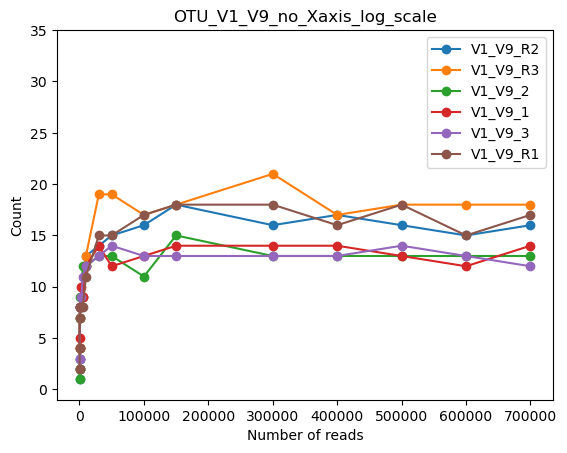

In [24]:
fig, ax = plt.subplots()
for sample in result_long['sample_name'].unique():
    subset = result_long[result_long['sample_name'] == sample]
    ax.plot(subset['number_of_reads'], subset['OTU_count_nonzero'], marker='o', linestyle='-', label=sample)

ax.set_xlabel('Number of reads')
ax.set_ylabel('Count')
ax.set_title('OTU_V1_V9_no_Xaxis_log_scale')
ax.set_ylim(-1, 35)
#ax.set_xscale('log')
#ax.xaxis.set_ticks(result_melted["number_of_reads"])
ax.legend()
plt.show()
#plt.savefig('OTU_V3_V4.png')

In [29]:
result_pivot = result_long.pivot(index='number_of_reads', columns='sample_name', values='OTU_count_nonzero')
result_final = result_pivot.reset_index()
result_final.columns.name = None
result_final = result_final.fillna(0)
pd.to_numeric(result_final["number_of_reads"])
result_final.sort_values('number_of_reads',ascending=True)
#result_final.to_csv('OTU_result_final_test.csv',sep='\t')

,number_of_reads,V3_V4_1,V3_V4_2,V3_V4_3,V3_V4_R1,V3_V4_R2,V3_V4_R3
0,50,1.0,1.0,1.0,1.0,0.0,0.0
1,100,1.0,2.0,1.0,2.0,0.0,2.0
2,150,2.0,1.0,2.0,1.0,3.0,2.0
3,200,4.0,4.0,5.0,8.0,5.0,4.0
4,250,8.0,7.0,7.0,8.0,8.0,7.0
5,300,8.0,8.0,8.0,8.0,8.0,8.0
6,500,10.0,8.0,9.0,8.0,8.0,8.0
7,1000,11.0,10.0,9.0,10.0,9.0,8.0
8,3000,12.0,12.0,9.0,8.0,10.0,8.0
9,5000,9.0,12.0,10.0,8.0,9.0,8.0


In [21]:
result_melted = pd.melt(result_final, id_vars=['number_of_reads'], var_name='line', value_name='value')

In [ ]:
samples = pd.Series([col.rsplit('_', 2)[0] for col in result.columns]).drop_duplicates().tolist()
samples

In [ ]:
reads = pd.Series([col.split('_')[-2] for col in result.columns]).drop_duplicates().tolist()
reads.sort()
reads

TESTING RESHAPING DF ON DUMMY DATA

In [ ]:
# Assuming your initial dataframe is named df
data = {
    'V3_V4_1_100_reads': [10],
    'V3_V4_2_100_reads': [15],
    'V3_V4_3_100_reads': [20],
    'V3_V4_1_500_reads': [30],
    'V3_V4_2_500_reads': [30],
    'V3_V4_3_500_reads': [35]
}

df = pd.DataFrame(data)

# Melt the dataframe to go from wide to long format
df_long = df.melt(var_name='column', value_name='OTU_count_nonzero')

In [ ]:
df

In [ ]:
df_long

In [ ]:
# Extract sample names and number of reads
df_long['sample_name'] = df_long['column'].str.extract(r'(V3_V4_\d+)_\d+_reads')
df_long

In [ ]:
df_long['number_of_reads'] = df_long['column'].str.extract(r'V3_V4_\d+_(\d+)_reads')
df_long

In [ ]:
# Drop the original column names as they are no longer needed
df_long.drop('column', axis=1, inplace=True)
df_long

In [ ]:
# Pivot the table to get the desired format
df_pivot = df_long.pivot(index='number_of_reads', columns='sample_name', values='OTU_count_nonzero')
df_pivot

In [ ]:
# Reset the index to get number_of_reads as a column
df_final = df_pivot.reset_index()
df_final

In [ ]:
# Optionally, sort by number_of_reads if needed
df_final.columns

In [ ]:
df_final.columns.name = None
# Print the final dataframe
print(df_final)

**GENUS**

PLOTS

In [ ]:
Color_collection = {}

for i in data_tax_df.index:
    
    Color_collection[i] = get_color(Color_collection)

In [ ]:
import plotly.express as px
import plotly.subplots as sp

fig = px.bar(data_tax_df.T, 
             x=data_tax_df.columns, 
             y=data_tax_df.index,
             width=1500, 
             height=900, 
            # color=data_tax_df.index,
             labels={'value': 'Relative abundance', 'index':'Samples'}, 
             template='simple_white',
             color_discrete_map=Color_collection)
fig.update_layout(yaxis_range=[0, 1], legend_title_text='Taxon', legend_title_side='top center')
fig.update_traces(marker_line_width=1.1, marker_line_color='#202020', opacity=0.8)
fig.update_yaxes(ticksuffix = "  ")
fig.update_xaxes(range=[-1, len(mearged_otu_table.T)+0.2], autorangeoptions_clipmax=len(data_tax_df.T))

#fig.update_layout(showlegend=False)
#os.mkdir("VIZ")
fig.write_image(f"VIZ/16S_{taxonomy_level}.pdf")
fig.write_image(f"VIZ/16S_{taxonomy_level}.png", scale=5)
fig.show()